cluster
0     55
1    103
2    160
3    136
Name: count, dtype: int64


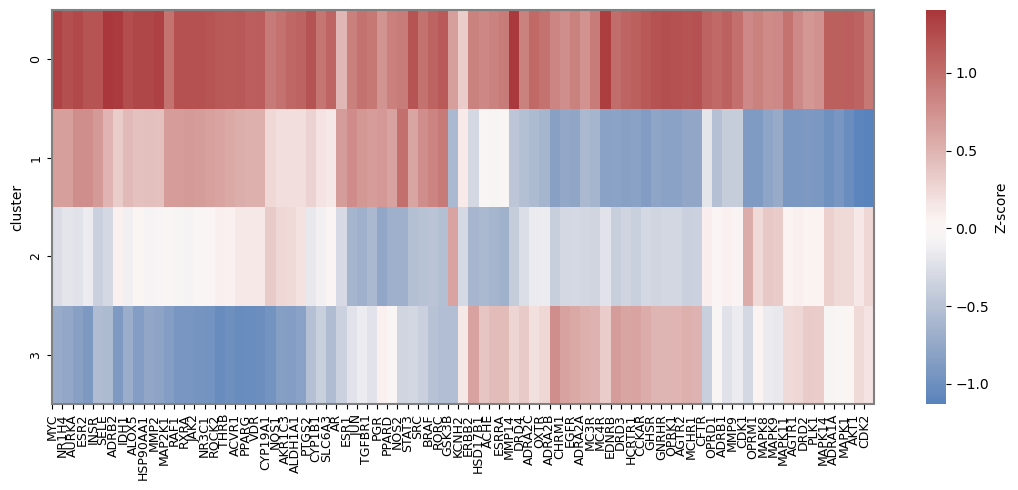

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from scipy.cluster.hierarchy import linkage, leaves_list
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# ========= 1) Load data =========
# Assume your DataFrame 'df' contains samples as rows and targets as columns (index = sample ID)
df = pd.read_excel('predict_data/positive_high.xlsx', index_col=0)

# Filter samples with higher overall activation
df["mean"] = df.mean(axis=1)
df.sort_values(by='mean', ascending=False)
df = df[df['mean'] >= 6]
df.drop(columns='mean', inplace=True)

# ========= 2) Preprocessing =========
# Standardization (column-wise: each target with mean=0, std=1)
scaler = StandardScaler()
X = scaler.fit_transform(df.values)

# ========= 3) Train K-Means and assign cluster labels =========
k = 4 
kmeans = KMeans(n_clusters=k, random_state=42, n_init="auto")
labels = kmeans.fit_predict(X)

df_clusters = df.copy()
df_clusters["cluster"] = labels
print(df_clusters["cluster"].value_counts().sort_index())

# Mean activation profile per cluster in standardized space
cluster_profiles = (
    pd.DataFrame(X, index=df.index, columns=df.columns)
      .assign(cluster=labels)
      .groupby("cluster")
      .mean()
)

# Each sample’s cluster label
labels_out = pd.DataFrame({"sample": df.index, "cluster": labels}).set_index("sample")

# Mean receptor profile per cluster in the original (non-standardized) scale — easier for interpretation
cluster_means_raw = df.assign(cluster=labels).groupby("cluster").mean()

# ========= 4) Hierarchical ordering of columns (targets) =========
col_linkage = linkage(cluster_profiles.T, method='average', metric='euclidean')
col_order = leaves_list(col_linkage)
ordered_cols = cluster_profiles.columns[col_order]

# ========= 5) Visualization =========
plt.figure(figsize=(11, 5))
ax = sns.heatmap(
    cluster_profiles[ordered_cols],
    cmap="vlag",
    center=0,
    cbar_kws={"label": "Z-score"},
    linewidths=0.001,          # Fine gridlines between cells (optional)
    linecolor='white'          # Gridline color
)

# Customize x-axis labels
ax.set_xticks(range(len(ordered_cols)))
ax.set_xticklabels(ordered_cols, rotation=90, fontsize=9)

# Add a visible border around the heatmap
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1.5)    # Border thickness
    spine.set_edgecolor('grey') # Border color

plt.yticks(fontsize=9)
plt.tight_layout()

plt.show()


In [3]:
import numpy as np
import pandas as pd
from scipy.stats import zscore, kruskal
from statsmodels.stats.multitest import multipletests

def summarize_toxic_subtypes(df_targets: pd.DataFrame,
                             labels: pd.Series,
                             y_toxic: None,
                             top_n: int = 11,
                             standardize_per_target: bool = True):
    """
    Return four summary tables:
    1) cluster_profiles: the mean target profile of each cluster 
       (optionally standardized by z-scoring each target across samples)
    2) cluster_top_targets: for each cluster, the top-N targets showing 
       the largest positive and negative deviations relative to the global mean 
       (representing characteristic "toxicological subtypes")
    3) cluster_stats: per-cluster statistics including the number of samples, 
       toxic fraction (optional), and representative target summary
    4) per_target_kruskal: Kruskal–Wallis test results assessing 
       overall differences of each target across clusters
    """
    assert df_targets.index.equals(labels.index), "labels index must match df_targets"
    if y_toxic is not None:
        assert df_targets.index.equals(y_toxic.index), "y_toxic index must match df_targets"

    X = df_targets.copy()
    # (Optional) Standardize each target (z-score per column) to make them comparable;
    # set False if standardization has already been performed
    if standardize_per_target:
        X = X.apply(zscore, axis=0, nan_policy='omit')
    
    # 1) Mean profile for each cluster
    cluster_profiles = X.assign(cluster=labels).groupby("cluster").mean()

    # 2) Relative change compared to the global mean (cluster mean - overall mean)
    global_mean = X.mean(axis=0)
    delta = cluster_profiles.subtract(global_mean, axis=1)

    # Select Top-N upregulated and downregulated targets as cluster “feature signatures”
    rows = []
    for c in delta.index:
        s = delta.loc[c].sort_values(ascending=False)
        top_up = s.head(top_n).index.tolist()
        top_down = s.tail(top_n).index.tolist()
        rows.append({"cluster": c,
                     "top_up_targets": top_up,
                     "top_down_targets": top_down})
    cluster_top_targets = pd.DataFrame(rows).set_index("cluster")

    # 3) Cluster summary: sample count, toxic fraction (if provided), concise label
    stats = labels.value_counts().sort_index().rename("n_samples").to_frame()
    if y_toxic is not None:
        tox_rate = pd.crosstab(labels, y_toxic, normalize='index').get(1, pd.Series(0, index=stats.index))
        stats["toxic_fraction"] = tox_rate
    # Generate a short subtype label (Top 5 upregulated targets)
    stats["subtype_signature"] = cluster_top_targets["top_up_targets"].apply(lambda xs: ", ".join(xs[:top_n]))
    cluster_stats = stats

    # 4) (Optional) Test whether each target differs significantly across clusters (Kruskal–Wallis)
    kr_rows = []
    for t in X.columns:
        groups = [X.loc[labels == c, t].dropna().values for c in sorted(labels.unique())]
        if sum(len(g) > 0 for g in groups) >= 2:
            H, p = kruskal(*groups, nan_policy='omit')
            kr_rows.append({"target": t, "H": H, "p": p})
    per_target_kruskal = pd.DataFrame(kr_rows)
    if not per_target_kruskal.empty:
        per_target_kruskal["q"] = multipletests(per_target_kruskal["p"], method="fdr_bh")[1]
        per_target_kruskal = per_target_kruskal.sort_values("q")

    return cluster_profiles, cluster_top_targets, cluster_stats, per_target_kruskal


In [4]:
cluster_profiles, cluster_top_targets, cluster_stats, per_target_kruskal = summarize_toxic_subtypes(
    df_targets=df,
    labels=labels_out['cluster'],
    y_toxic=None,
    top_n=10,
    standardize_per_target=True
)

print(cluster_stats)         
cluster_top_targets     

         n_samples                                  subtype_signature
cluster                                                              
0               55  SELE, MMP14, ADRB2, MC4R, MMP2, MYC, HSP90AA1,...
1              103  NOS2, RORC, BRAF, ESR1, ESR2, SRC, AURKA, JUN,...
2              160  GSK3B, CDK1, MAPK8, CYP19A1, MAPK9, MAPK14, CD...
3              136  ADRA2B, EDNRB, ERBB2, CHRM1, HCRTR1, DRD3, EGF...


,top_up_targets,top_down_targets
cluster,,
0,"[SELE, MMP14, ADRB2, MC4R, MMP2, MYC, HSP90AA1...","[CDK1, MAPK8, CHRM1, PLK1, ADRA2A, PGR, DRD2, ..."
1,"[NOS2, RORC, BRAF, ESR1, ESR2, SRC, AURKA, JUN...","[OPRM1, DRD2, MAPK11, PLK1, AGTR1, ADRA1A, MAP..."
2,"[GSK3B, CDK1, MAPK8, CYP19A1, MAPK9, MAPK14, C...","[TGFBR1, HSD17B1, ERBB2, ACHE, ESR1, ESRRA, JU..."
3,"[ADRA2B, EDNRB, ERBB2, CHRM1, HCRTR1, DRD3, EG...","[RXRA, RAF1, JAK2, CYP19A1, NR3C1, THRB, VDR, ..."


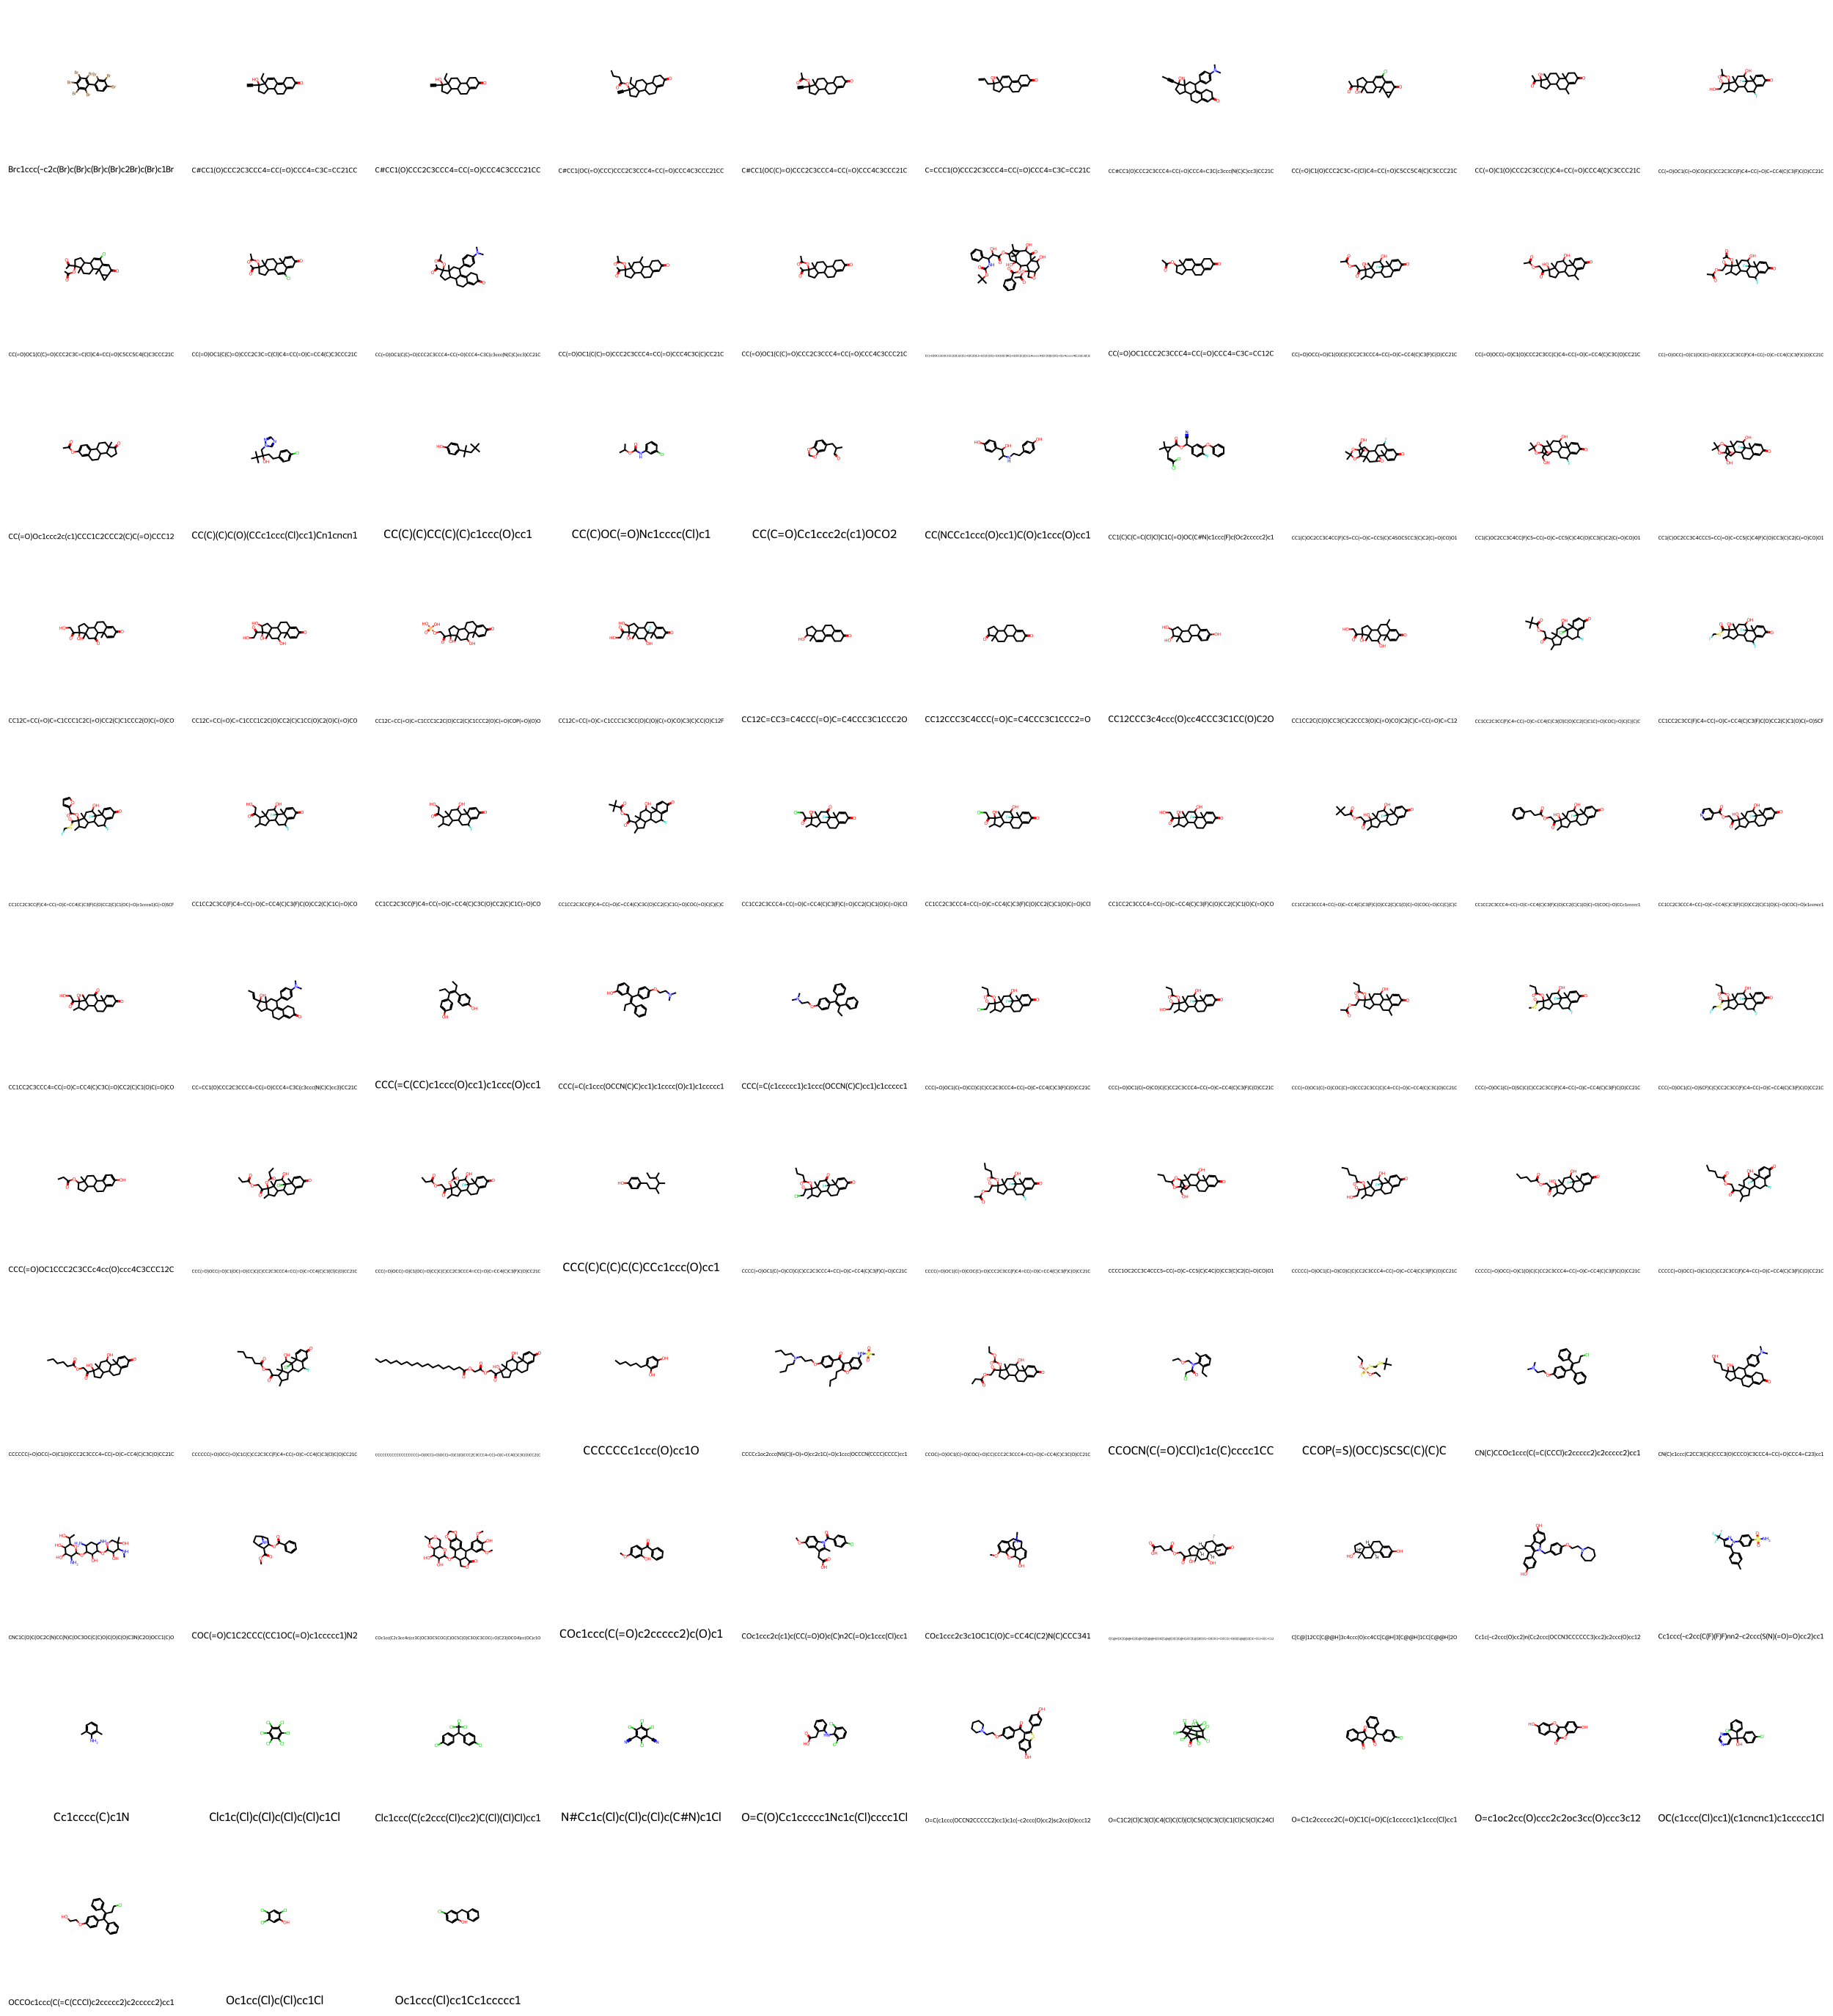

In [ ]:
df_smi = pd.read_excel('tox_smi_dedup.xlsx')
df_smi = df_smi[df_smi['Label']=='Positive']
label1 = labels_out[labels_out['cluster'] == 1]
df_smi1 = df_smi[df_smi['CAS RN'].isin(label1.index)]
smiles_list = df_smi1['new_smiles'].tolist()
from rdkit.Chem import Draw
from rdkit import Chem
import pandas as pd
mols = []
legends = []
for s in smiles_list:
    mol = Chem.MolFromSmiles(s)
    if mol is not None:
        mols.append(mol)
        legends.append(s)  

# draw
img = Draw.MolsToGridImage(
    mols, 
    molsPerRow=10,    
    subImgSize=(250,250), 
    legends=legends, 
    useSVG=False,
    maxMols=len(mols) 
)

img